# Technical test for the data science internship @Hyperlex

In [308]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


In [309]:
import os
import warnings
warnings.filterwarnings('ignore')
import itertools as it
import codecs
import json
import numpy as np
import pandas as pd

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

from nltk.tokenize import RegexpTokenizer , word_tokenize, sent_tokenize
from nltk.stem.snowball import SnowballStemmer

# from nltk.corpus import stopwords
import spacy #be sure to use version 1.9.0
from gensim.models import Phrases
from gensim.models.phrases import Phraser  #it's faster according to gensim
from gensim.models.word2vec import LineSentence

import re
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

2019-01-28 20:14:44,398 - matplotlib.backends - DEBUG - backend module://ipykernel.pylab.backend_inline version unknown


In [321]:
#!find . -iname *checkpoint* -type d -exec rm -r {} +  

FIND: Parameter format not correct


## Importing Data

In [322]:
rootdir = 'dataset'
json_files = [os.path.join(dirpath, file) for dirpath,_,files in os.walk(rootdir) for file in files if file.endswith('json')]

contracts = []
for file in json_files:
    with open(file) as f:
        contracts.append(json.load(f)['clauses'][1:])  # starting from one to skip the summary since they contain different informations 
                                                  # and could affect the clustering
            
contracts_df = pd.DataFrame(contracts)

## Cleaning Data

In [323]:
# adding number of clauses colomn in contracts_df for later analysis
contracts_df['num_clauses'] = contracts_df.notna().sum(axis=1)

Text(0.5,1,'number of clauses per contract')

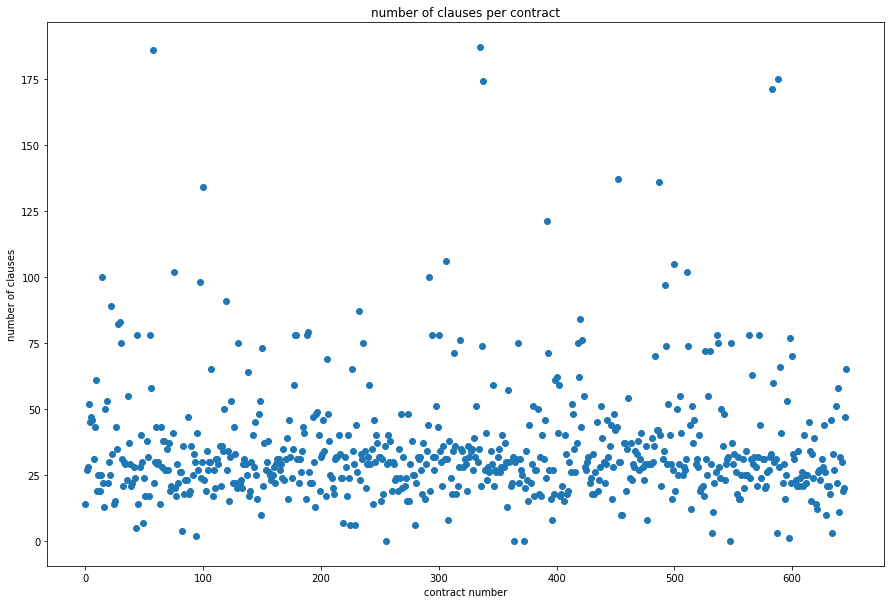

In [324]:
plt.figure(figsize=(15,10))
plt.scatter([range(contracts_df.shape[0])],contracts_df['num_clauses'])
plt.xlabel('contract number')
plt.ylabel('number of clauses')
plt.title('number of clauses per contract')

We can observe that we have some outliers in the corpus (probably due to bad parsing)
after observing the json files, I deemed it fit to just drop them (badly parsed)

In [325]:
contracts_df[contracts_df['num_clauses']<5] 

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,num_clauses
82,ARTICLE 1 FORME] La Société a été constituée s...,ARTICLE 5 La durée DUREE de la Société reste f...,ARTICLE 21 CONVENTIONS ENTRE LA SOCIETE ET SES...,ARTICLE 34 CAPITAUX PROPRES INFERIEURS A LA MO...,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,4
94,ARTICLE 2 OBJE La Société a pour objet : e La ...,ARTICLE 5 DUREE La durée de la Société est fix...,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,2
255,None,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,0
364,None,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,0
372,None,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,0
532,14.1 Pouvoirs du Président Le Président assume...,ARTICLE 15. Directeur général. L associé uniqu...,ARTICLE 16. Rémunération du président et du di...,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,3
547,None,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,0
587,ARTICLE 1 Il est formé à Paris une association...,ARTICLE 2 L association est ouverte a tout Isr...,ARTICLE 3 Le comité se réuni autant de fois qu...,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,3
597,CHAPITRE i : DEcisioNS COLLECTVES pneuen ronue...,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,1
634,ARTICLE 1 Il est formé à Paris une association...,ARTICLE 2 L association est ouverte à tout Isr...,ARTICLE 3 Le comité se réuni autant de fois qu...,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,3


In [326]:
contracts_df.drop(index=[83,95,256,365,373,548,598],inplace=True) #leave those with seemingly coherent structure

In [327]:
contracts_df[contracts_df['num_clauses']>100]

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,num_clauses
57,ARTICLE 1. FORME 3 ARTICLE 2. DENOMINATION SOC...,ARTICLE 1. 1.1 DENOMINATION OBJET SIEGE SOCIAL...,1.2 Elle fonctionne indifféremment sous la mêm...,ARTICLE 2. DÉNOMINATION SOCIALE,2.1 La dénomination sociale est : « SANTE CIE ».,2.2 Tous les actes et documents émanant de la ...,"ARTICLE 3. OBJET La Société a pour objet, dire...",ARTICLE 4. 4.1 SIEGE SOCIAL Le siège social de...,4.2 Il peut être transféré en tout autre endro...,ARTICLE 5. DUREE La durée de la Société est de...,...,1.2 Valeur vénale des titres de la Société La ...,1.3 Valeur de Marché des Actions Cédées La Val...,2.1 En cas de désaccord sur la Valeur de March...,2.2 L Expert devra déterminer la Valeur de Mar...,2.3 L Expert pourra avoir accès à tous les doc...,2.4 L Expert devra déterminer la Valeur de Mar...,2.5 La décision de l Expert liera définitiveme...,2.6 Les frais et dépenses relatifs à la déterm...,None,186
75,"ARTICLE 1 FORME La Société, de forme société p...",ARTICLE 2 DÉNOMINATION SOCIALE La dénomination...,"ARTICLE 3 OBJET La Société a pour objet, direc...",ARTICLE 4 SIÈGE SOCIAL Le siège social de la S...,ARTICLE S DURÉE La durée de la Société est de ...,"ARTICLE 6 APPORTS Lors de la constitution, les...",ARTICLE 7 CAPITAL SOCIAL Le capital social est...,ARTICLE 8 8.1 MODIFICATIONS DU CAPITAL SOCIAL ...,8.2 L associé unique ou la collectivité des as...,ARTICLE 9 9.1 Les LIBÉRATION DES ACTIONS actio...,...,None,None,None,None,None,None,None,None,None,102
100,ARTICLE 1. ARTICLE 2. ARTICLE 3. ARTICLE 4. AR...,ARTICLE 1. 1.1 DENOMINATION OBJET SIEGE SOCIAL...,1.2 Elle fonctionne indifféremment sous la mêm...,ARTICLE 2. DENOMINATION SOCIALE 2.1 La dénomin...,2.2 Tous les actes et documents émanant de la ...,"ARTICLE 3. OBJET La Société a pour objet, dire...",ARTICLE 4. SIEGE SOCIAL,4.1 Le siège social de la Société est fixé : 3...,4.2 Il peut être transféré en tout autre endro...,ARTICLE 5. DUREE La durée de la Société est de...,...,None,None,None,None,None,None,None,None,None,134
306,ARTICLE 2 DÉNOMINATION SOCIALE La dénomination...,"ARTICLE 3 OBJET La Société a pour objet, direc...",ARTICLE 4 SIÈGE SOCIAL Le siège social de la S...,ARTICLE 5 DURÉE La durée de la Société est de ...,ARTICLE 7 7.1 MODIFICATIONS DU CAPITAL SOCIAL ...,7.2 L associé unique ou la collectivité des as...,ARTICLE 8 8.1 Les LIBÉRATION DES ACTIONS actio...,8.2 Les appels de fonds sont portés à la conna...,"ARTICLE 9 FORME, CESSION ET TRANSMISSION DES A...",9.1 Les actions sont nominatives.,...,None,None,None,None,None,None,None,None,None,106
335,ARTICLE 2. DÉNOMINATION SOCIALE La dénominatio...,"ARTICLE 3. OBJET La Société a pour objet, dire...",ARTICLE 4. SIEGE SOCIAL Le siège social de la ...,"ARTICLE 5. DUREE La Société, sauf en cas de pr...",ARTICLE 7. CAPITAL SOCIAL Le capital social es...,ARTICLE 8. 8.1 MODIFICATIONS DU CAPITAL Le cap...,8.2 L associé unique ou la collectivité des as...,ARTICLE 9. LIBÉRATION DES ACTIONS,9.1 Les actions souscrites en numéraire doiven...,9.2 Les appels de fonds du surplus sont portés...,...,28.3 Pour les besoins de l article R.228 20 du...,28.4 Les Actions D rachetées seront annulées.,ARTICLE 29. CONTESTATIONS,"29.1 Toutes les contestations qui, pendant la ...","29.2 A cet effet, en cas de contestation, les ...",2.1 Détermination du Montant B1 Le Montant B1 ...,2.2 Détermination du Montant C Préalablement à...,2.3 Détermination du Montant B2 Le Montant B2 ...,1.1 Détermination du Montant Bl Le Montant B1 ...,187
338,ARTICLE 2 DÉNOMINATION SOCIALE La dénomination...,"ARTICLE 3 OBJET La Société a pour objet, direc...",ARTICLE 4 SIÈGE SOCIAL,4.1 Le siège social de la Société est fixé : 6...,4.2 Il peut être transféré en tout autre endro...,ARTICLE 5 DUREE La durée de la Société est de ...,ARTICLE 6 6.1 CAPITAL SOCIAL MODIFICATIONS DU ...,6.2 Aux terme des décisions de l associé uniqu...,6.3 Aux termes des décisions de l associé uniq...,ARTICLE 7 CAPITAL SOCIAL Le capit

In [328]:
contracts_df.loc[[58,101,589],0] = None # badly parsed

Text(0,0.5,'number of clauses')

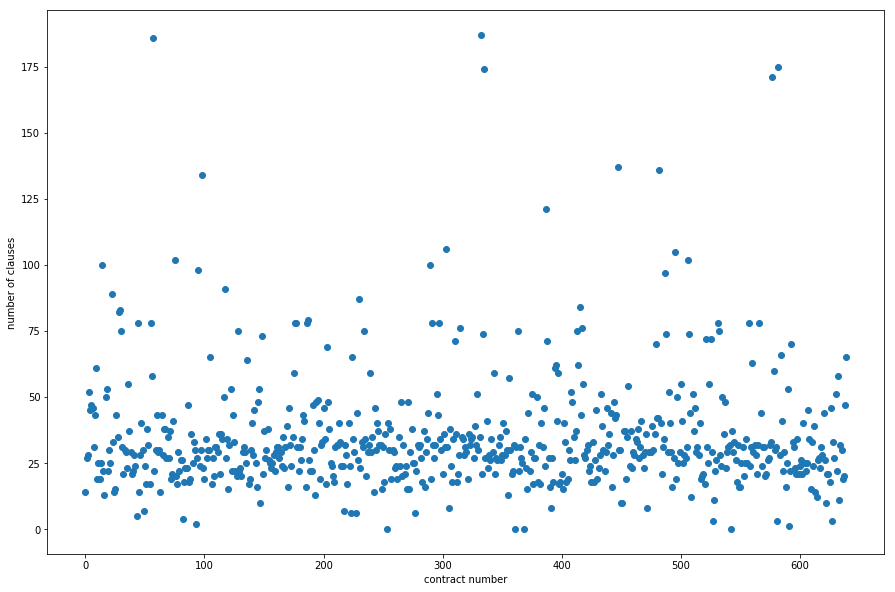

In [329]:
plt.figure(figsize=(15,10))
plt.scatter([range(contracts_df.shape[0])],contracts_df['num_clauses'])
plt.xlabel('contract number')
plt.ylabel('number of clauses')

In [330]:
contracts_df.describe() #to have an idea about the number of clusters 

,num_clauses
count,640.000000
mean,35.115625
std,22.931259
min,0.000000
25%,23.000000
50%,30.000000
75%,39.000000
max,187.000000


In [331]:
clauses_df = contracts_df.drop('num_clauses',axis=1).values.flatten()
clauses_df = clauses_df[clauses_df != np.array(None)]
clauses_df = pd.DataFrame(clauses_df)
clauses_df.describe()

,0
count,22471
unique,18762
top,"ARTICLE 10 FORME, CESSION ET TRANSMISSION DES ..."
freq,30


Although the duplicates won't affect the averaging used to find the kMeans centroids (for kmeans algorithm), I still decided to remove them because I only need unique descriptions to perform the clustering. Note that dropping duplicates will still keep one of those entries in the set.

In [332]:
clauses_df.drop_duplicates(inplace=True)
clauses_df.index = range(len(clauses_df.index)) # faster than reset_index
clauses_df.describe()

,0
count,18762
unique,18762
top,ARTICLE 17 Cessation d activité Retrait 1. Ces...
freq,1


In [101]:
clauses_df.drop_duplicates(inplace=True)
clauses_df.index = range(len(clauses_df.index)) # faster than reset_index
clauses_df.describe()

,0
count,18767
unique,18767
top,ARTICLE 17 Cessation d activité Retrait 1. Ces...
freq,1


In [333]:
clauses_df['length'] = clauses_df[0].str.len()

Text(0,0.5,'Clause length (in terms of words)')

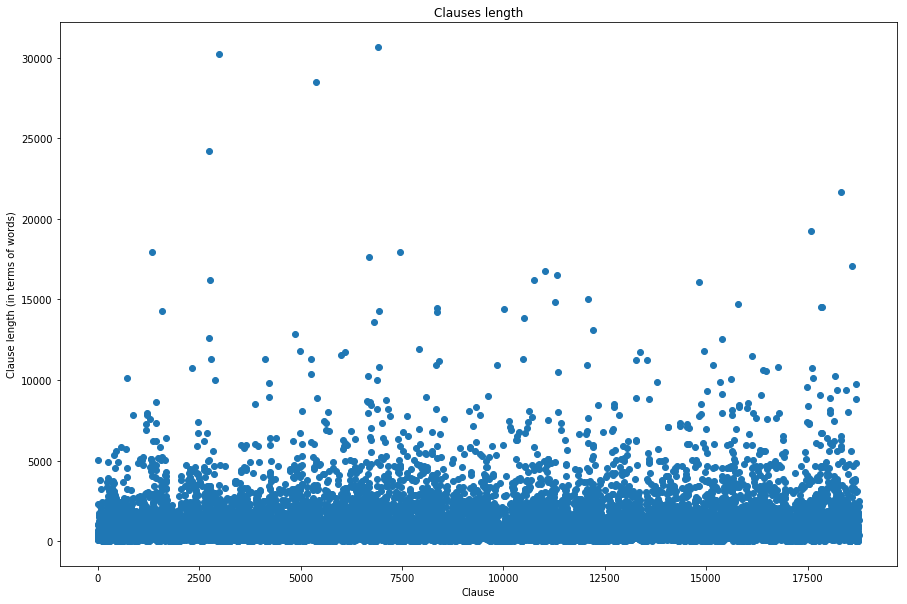

In [334]:
# clauses_lengths = [len(clause[0]) for clause in clauses_df.values]
# clauses_df['length'] = clauses_lengths
plt.figure(figsize=(15,10))
plt.scatter([range(len(clauses_df['length']))], clauses_df['length'].values)
plt.title('Clauses length')
plt.xlabel('Clause')
plt.ylabel(r'Clause length (in terms of words)')

here as well we can observe several outliers (either too short or too long). let's have a look at them

In [335]:
clauses_df.describe()

,length
count,18762.000000
mean,1018.148492
std,1369.109966
min,9.000000
25%,309.000000
50%,611.000000
75%,1223.750000
max,30657.000000


In [336]:
# the 16000 threshold was heuristically chosen after several observations of the article. this is when the main parsing problems begin
clauses_df[clauses_df.length > 16000].sort_values('length')

,0,length
14819,ARTICLE 17 Pouvoirs de la gérance En cas de pl...,16070
10762,Article 8 Capital social Le capital social est...,16180
2771,Article 12 1 Cession et transmission des parts...,16198
11331,ARTICLE 35. CONTESTATIONS Toutes contestations...,16540
11020,"22.3 Nonobstant ce qui précède, il pourra être...",16741
18585,19.1 Mode de consultation des associés Les ass...,17044
6676,"18.3 ""ounve ctrur eéng Le directeur général di...",17639
1341,4.3 Droit préférentiel de souscription En cas ...,17930
7459,"ARTICLE 12 SOUSCRIPTION, LIBERATION ET REPRESE...",17936
17596,CHAPITRE i : DEcisioNS COLLECTVES pneuen ronue...,19258


In [337]:
clauses_df.drop(clauses_df[clauses_df.length > 16000].index, inplace=True)

In [343]:
clauses_df[clauses_df.length < 15].sort_values('length')

,0,length
16026,8.1 Forme,9
14601,Article 6,9
9142,ARTICLE 9,9
7192,Article 9,9
13678,ARTICLE 19,10
11203,CHAPITRE 2,10
1752,ARTICLE 14,10
1789,ARTICLE 25,10
15651,ARTICLE 13,10
14636,Article 13,10


the problem with short parsed clauses is mainly because of the hierarchical presentation of some clauses 

1. clause x :

    1.1. line 1
    
    1.2. line 2
    
one way to solve this is to do some kind of inner correspondance of clauses inside the same article (that if we don't want to work directly with tons of regex to clean the dataset


Text(0,0.5,'Clause length (in terms of words)')

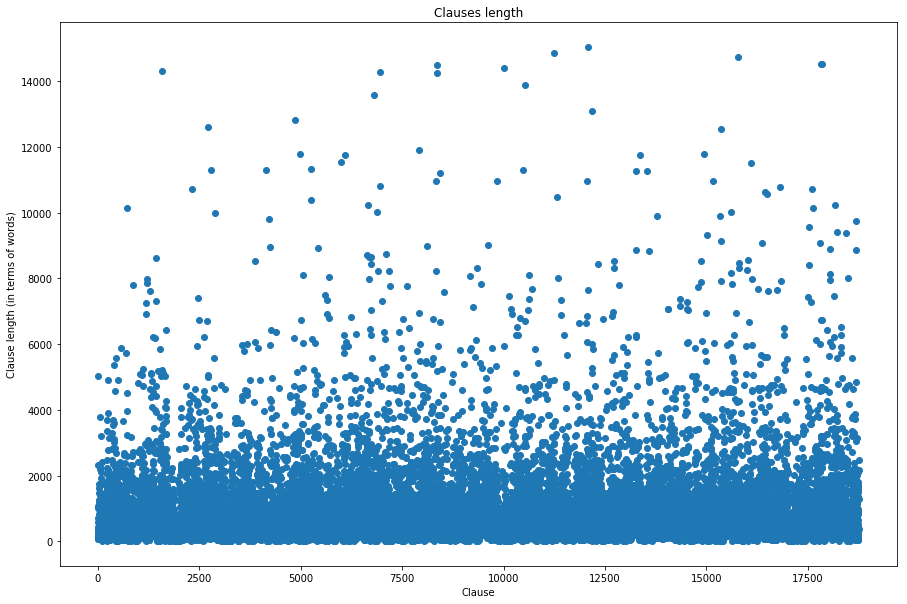

In [107]:
plt.figure(figsize=(15,10))
plt.scatter([range(len(clauses_df['length']))], clauses_df['length'].values)
plt.title('Clauses length')
plt.xlabel('Clause')
plt.ylabel(r'Clause length (in terms of words)')

## Pre-processing pipeline :

before editing the data, we can extract the "labels" of each clause (for evaluation purposes)
1. **Tokenization** (nltk word tokenizer should be good)  . check out spacy as well  
2. possible way to clean data :
    * delete all numerical and alphanumerical words
    * delete "ARTICLE x.x"
    * delete punctuation
3. **lower case**
4. explore the possibility of combining some "special words" into n-grams
5. **lemmatization**
6. **stop words**
7. **Phrase Modeling** (unigrams, bigrams and trigrams)
8. **Save your work** 

In [344]:
clauses = clauses_df[0].values   # faster and easier than to loop on a df

this part of the code was mainly based on this pretty detailed [example](https://github.com/skipgram/modern-nlp-in-python/blob/master/executable/Modern_NLP_in_Python.ipynb)

In [345]:
%%time
nlp = spacy.load('fr')

Wall time: 6.02 s


### Phrase Modeling

_Phrase modeling_ is another approach to learning combinations of tokens that together represent meaningful multi-word concepts. We can develop phrase models by looping over the the words in our reviews and looking for words that _co-occur_ (i.e., appear one after another) together much more frequently than you would expect them to by random chance. The formula our phrase models will use to determine whether two tokens $A$ and $B$ constitute a phrase is:

$$\frac{count(A\ B) - count_{min}}{count(A) * count(B)} * N > threshold$$

...where:
* $count(A)$ is the number of times token $A$ appears in the corpus
* $count(B)$ is the number of times token $B$ appears in the corpus
* $count(A\ B)$ is the number of times the tokens $A\ B$ appear in the corpus *in order*
* $N$ is the total size of the corpus vocabulary
* $count_{min}$ is a user-defined parameter to ensure that accepted phrases occur a minimum number of times
* $threshold$ is a user-defined parameter to control how strong of a relationship between two tokens the model requires before accepting them as a phrase

Once our phrase model has been trained on our corpus, we can apply it to new text. When our model encounters two tokens in new text that identifies as a phrase, it will merge the two into a single new token. (and redo the same thing for 3 tokens)

As we're performing phrase modeling, we'll be doing some iterative data transformation at the same time. Our roadmap for data preparation includes:

1. Segment text of complete reviews into sentences & normalize text
1. First-order phrase modeling $\rightarrow$ _apply first-order phrase model to transform sentences_
1. Second-order phrase modeling $\rightarrow$ _apply second-order phrase model to transform sentences_
1. Apply text normalization and second-order phrase model to text of complete reviews

We'll use this transformed data as the input for some higher-level modeling approaches in the following sections.

First, let's define a few helper functions that we'll use for text normalization. In particular, the `lemmatized_sentence_corpus` generator function will use spaCy to:
- Iterate over the 18k (which is not that big) clauses
- Segment the clauses into individual sentences
- Remove punctuation and excess whitespace
- Lemmatize the text

... and do so efficiently in parallel, thanks to spaCy's `nlp.pipe()` function.

In [ ]:
from french_lefff_lemmatizer.french_lefff_lemmatizer import FrenchLefffLemmatizer

In [347]:
def filter_token(token):
    """
    helper function to eliminate tokens
    that are pure punctuation or whitespace
    """
    
    return token.is_punct or token.is_space  or token.like_num #or str(token).lower() == 'article'

def ram_saver(clauses):
    """
    helper function to transform the clauses list (iterator)
    into a generator
    """
    for clause in clauses:
        yield clause

def lemmatized_sentence_corpus(clauses,lemmatizer = None ):
    """
    generator function to use spaCy to parse clauses,
    lemmatize the text, and yield sentences
    lemmatizer = provide a costum lemmatizer or use spacy's by default
    """
    
    for parsed_clause in nlp.pipe(ram_saver(clauses),
                                  batch_size=512):
        
        for sent in parsed_clause.sents:
            #yield ' '.join([token.lemma_ for token in sent if not filter(token)])
            if lemmatizer :
                yield ' '.join([lemmatizer.lemmatize(token.text) for token in sent 
                            if not filter_token(token)]) 
            else :
                yield ' '.join([token.lemma_ for token in sent 
                            if not filter_token(token)]) 
                
def lemmatized_token_corpus(clauses, lemmatizer = None ):
    """
    generator function to use spaCy to parse clauses,
    lemmatize the text, and yield tokenzid clauses
    lemmatizer = provide a costum lemmatizer or use spacy's by default
    """
    
    for parsed_clause in nlp.pipe(ram_saver(clauses),
                                  batch_size=512):
        
        tokenized_clause = []
        for token in parsed_clause:
            #yield ' '.join([token.lemma_ for token in sent if not filter(token)])
            if lemmatizer :
                if not filter_token(token) :
                    tokenized_clause.append(lemmatizer.lemmatize(token.text))
            else :
                if not filter_token(token) :
                     tokenized_clause.append(token.lemma_)
        yield ' '.join(tokenized_clause)
                

In [348]:
intermediate_directory = os.path.join('.', 'intermediate') # this folder is where I save all the intermediate files
unigram_clauses_filepath = os.path.join(intermediate_directory,
                                          'unigram_clauses.txt')

In [351]:
%%time

# the if statement is avoid running the same code ,but read from disk instead
if False:

    with codecs.open(unigram_clauses_filepath, 'w', encoding='utf_8') as f:
        for tokenized_clause in lemmatized_token_corpus(clauses, FrenchLefffLemmatizer()):
            f.write(tokenized_clause + '\n')

Wall time: 13min 13s


since our `unigram_sentences_all` file now is  a large text file with one document/sentence per line , gensim's [**LineSentence**](https://radimrehurek.com/gensim/models/word2vec.html#gensim.models.word2vec.LineSentence) class provides a convenient iterator for working with other gensim components. It *streams* the documents/sentences from disk, so that we never have to hold the entire corpus in RAM at once. This allows us to scale our modeling pipeline up to potentially very large corpora.

In [352]:
unigram_clauses = LineSentence(unigram_clauses_filepath)

In [382]:
for unigram_clause in it.islice(unigram_clauses, 230, 240):
    print( ' '.join(unigram_clause))
    print()

2019-01-28 21:13:31,454 - smart_open.smart_open_lib - DEBUG - {'kw': {}, 'mode': 'rb', 'uri': '.\\intermediate\\unigram_clauses.txt'}
article consultation écrite En cas de consultation par correspondance en ce compris toute consultation effectuée par télécopie ou par transmission électronique le texte des résolution proposées et bulletin de vote correspondant ainsi que les document nécessaire à l information des associé sont adressés par le demandeur à chaque associé par tous moyens de communication écrite en ce compris la télécopie et le courriel Les associé disposent d délai de jour à compter de la réception des projet de résolution pour adresser leur vote et le bulletin de vote au demandeur Le vote peut être émis par tous moyens de communication écrite en ce compris la télécopie et le courriel si les vote de tous les associé sont reçu avant l expiration dudit délai la ou les résolution(s concernée(s sera(ont réputée(s avoir fait l objet d vote à la date de réception du dernier vote 

In [355]:
bigram_model_filepath = os.path.join(intermediate_directory, 'bigram_model_all')

In [356]:
%%time
if False:
    bigram_model = Phraser(Phrases(unigram_clauses));

    bigram_model.save(bigram_model_filepath)
#load the finished model from disk
bigram_model = Phraser.load(bigram_model_filepath)

2019-01-28 20:50:36,384 - gensim.models.phrases - INFO - collecting all words and their counts
2019-01-28 20:50:36,386 - smart_open.smart_open_lib - DEBUG - {'kw': {}, 'mode': 'rb', 'uri': '.\\intermediate\\unigram_clauses.txt'}
2019-01-28 20:50:36,389 - gensim.models.phrases - INFO - PROGRESS: at sentence #0, processed 0 words and 0 word types
2019-01-28 20:50:38,968 - gensim.models.phrases - INFO - PROGRESS: at sentence #10000, processed 1540629 words and 155609 word types
2019-01-28 20:50:41,374 - gensim.models.phrases - INFO - collected 231894 word types from a corpus of 2987836 words (unigram + bigrams) and 18747 sentences
2019-01-28 20:50:41,376 - gensim.models.phrases - INFO - using 231894 counts as vocab in Phrases<0 vocab, min_count=5, threshold=10.0, max_vocab_size=40000000>
2019-01-28 20:50:41,377 - gensim.models.phrases - INFO - source_vocab length 231894
2019-01-28 20:50:43,438 - gensim.models.phrases - INFO - Phraser built with 4624 4624 phrasegrams
2019-01-28 20:50:43,44

Now that we have a trained phrase model for word pairs, let's apply it to the review sentences data and explore the results.

In [360]:
bigram_clauses_filepath = os.path.join(intermediate_directory,
                                         'bigram_clauses.txt')

In [359]:
%%time
if False:
    with codecs.open(bigram_clauses_filepath, 'w', encoding='utf_8') as f:

        for unigram_clause in unigram_clauses:

            bigram_clause = ' '.join(bigram_model[unigram_clause])

            f.write(bigram_clause + '\n')

2019-01-28 20:51:12,171 - smart_open.smart_open_lib - DEBUG - {'kw': {}, 'mode': 'rb', 'uri': '.\\intermediate\\unigram_clauses.txt'}
Wall time: 7.64 s


In [362]:
bigram_clauses = LineSentence(bigram_clauses_filepath)

In [363]:
for bigram_clause in it.islice(bigram_clauses, 230, 240):
    print (u' '.join(bigram_clause))
    print (u'')

2019-01-28 20:52:58,677 - smart_open.smart_open_lib - DEBUG - {'kw': {}, 'mode': 'rb', 'uri': '.\\intermediate\\bigram_clauses.txt'}
article consultation_écrite En_cas de consultation par correspondance en ce compris toute consultation effectuée par télécopie ou par transmission électronique le texte des résolution_proposées et bulletin de vote correspondant ainsi_que les document_nécessaire à l information des associé sont adressés par le demandeur à chaque associé par tous_moyens de communication_écrite en ce compris la télécopie et le courriel Les associé disposent d délai de jour à compter de la réception des projet de résolution pour adresser leur vote et le bulletin de vote au demandeur Le vote peut être émis par tous_moyens de communication_écrite en ce compris la télécopie et le courriel si les vote de tous les associé sont reçu avant l expiration_dudit délai la ou les résolution(s concernée(s sera(ont réputée(s avoir fait l objet d vote à la date de réception du dernier vote l

In [364]:
trigram_model_filepath = os.path.join(intermediate_directory,
                                      'trigram_model_all')

In [365]:
%%time
if False :
    trigram_model = Phraser(Phrases(bigram_clauses))

    trigram_model.save(trigram_model_filepath)

#load the finished model from disk
trigram_model = Phraser.load(trigram_model_filepath)

2019-01-28 20:53:17,775 - gensim.models.phrases - INFO - collecting all words and their counts
2019-01-28 20:53:17,778 - smart_open.smart_open_lib - DEBUG - {'kw': {}, 'mode': 'rb', 'uri': '.\\intermediate\\bigram_clauses.txt'}
2019-01-28 20:53:17,779 - gensim.models.phrases - INFO - PROGRESS: at sentence #0, processed 0 words and 0 word types
2019-01-28 20:53:20,120 - gensim.models.phrases - INFO - PROGRESS: at sentence #10000, processed 1405735 words and 168942 word types
2019-01-28 20:53:22,489 - gensim.models.phrases - INFO - collected 251630 word types from a corpus of 2726930 words (unigram + bigrams) and 18747 sentences
2019-01-28 20:53:22,491 - gensim.models.phrases - INFO - using 251630 counts as vocab in Phrases<0 vocab, min_count=5, threshold=10.0, max_vocab_size=40000000>
2019-01-28 20:53:22,493 - gensim.models.phrases - INFO - source_vocab length 251630
2019-01-28 20:53:25,322 - gensim.models.phrases - INFO - Phraser built with 15745 15745 phrasegrams
2019-01-28 20:53:25,3

We'll apply our trained second-order phrase model to our first-order transformed sentences, write the results out to a new file, and explore a few of the second-order transformed sentences.

In [366]:
trigram_clauses_filepath = os.path.join(intermediate_directory,
                                          'trigram_clauses.txt')

In [368]:
%%time

if False :
    with codecs.open(trigram_clauses_filepath, 'w', encoding='utf_8') as f:

        for bigram_clause in bigram_clauses:

            trigram_clause = ' '.join(trigram_model[bigram_clause])

            f.write(trigram_clause + '\n')

2019-01-28 20:53:51,198 - smart_open.smart_open_lib - DEBUG - {'kw': {}, 'mode': 'rb', 'uri': '.\\intermediate\\bigram_clauses.txt'}
Wall time: 7.3 s


In [369]:
trigram_clauses = LineSentence(trigram_clauses_filepath)

In [370]:
for trigram_clause in it.islice(trigram_clauses, 230, 240):
    print (u' '.join(trigram_clause))
    print (u'')

2019-01-28 20:54:12,689 - smart_open.smart_open_lib - DEBUG - {'kw': {}, 'mode': 'rb', 'uri': '.\\intermediate\\trigram_clauses.txt'}
article consultation_écrite En_cas de consultation par correspondance en ce_compris toute consultation effectuée par télécopie ou par transmission_électronique le texte des résolution_proposées et bulletin de vote correspondant ainsi_que les document_nécessaire à l information des associé sont_adressés par le demandeur à chaque associé par tous_moyens de communication_écrite en ce_compris la télécopie et le courriel Les associé disposent d délai de jour à compter de la réception des projet de résolution pour adresser leur vote et le bulletin de vote au demandeur Le vote peut être émis par tous_moyens de communication_écrite en ce_compris la télécopie et le courriel si les vote de tous les associé sont reçu avant l expiration_dudit_délai la ou les résolution(s concernée(s sera(ont réputée(s avoir fait l objet d vote à la date de réception du dernier vote 

The final step of our text preparation process circles back to the complete text of the clauses. We're going to run the complete text of the clauses through a pipeline that applies our text normalization and phrase models.
we'll also remove stopwords at this point

In [371]:
trigram_clauses_filepath = os.path.join(intermediate_directory,
                                        'trigram_transformed_clauses_all.txt')

In [383]:
%%time
if False :
    with codecs.open(trigram_clauses_filepath, 'w', encoding='utf_8') as f:
        
        for tokenized_clause in  unigram_clauses:
            # lemmatize the text, removing punctuation and whitespace
            unigram_clause = tokenized_clause
            # apply the first-order and second-order phrase models
            bigram_clause = bigram_model[unigram_clause]
            trigram_clause = trigram_model[bigram_clause]

            # remove any remaining stopwords
            trigram_clause = [term for term in trigram_clause
                              if term not in spacy.lang.fr.STOP_WORDS]

            # write the transformed clause as a line in the new file
            trigram_clause = ' '.join(trigram_clause)
            f.write(trigram_clause + '\n')

2019-01-28 21:16:44,792 - smart_open.smart_open_lib - DEBUG - {'kw': {}, 'mode': 'rb', 'uri': '.\\intermediate\\unigram_clauses.txt'}
Wall time: 15.2 s


In [385]:
print( 'Original:' + '\n')

for clause in it.islice(clauses, 11, 12):
    print (clause)

print ('----' + '\n')
print ('Transformed:' + '\n')

with codecs.open(trigram_clauses_filepath, encoding='utf_8') as f:
    for clause in it.islice(f, 11, 12):
        print (clause)

Original:

ARTICLE 13 1 Droits des associés ou de l associé unique Droits attribués aux parts Chaque part donne droit à une fraction des bénéfices et de l actif social proportionnellement au nombre de parts existantes. 2 Transmission des droits Les droits et obligations attachés aux parts les suivent dans quelque main qu elles passent. La propriété d une part emporte de plein droit adhésion aux statuts et aux résolutions réguliérement prises par les associés. Les représentants, peuvent, sous ayants quelque droit, prétexte conjoint que ce et soit, héritiers requérir d un associé l apposition ne des scellés sur les biens et valeurs de la société, ni en demander le partage ou la licitation. 3 Nantissement des parts Si la société a donné son consentement à un projet de nantissement de parts sociales, ce consentement emportera l agrément du cessionnaire en cas de réalisation forcée des parts nanties, selon ces conditions de l article 2078 du Code civil, à moins que la société ne préfère, ap

## Topic Modeling with Latent Dirichlet Allocation (_LDA_)

LDA is fully unsupervised. The topics are "discovered" automatically from the data by trying to maximize the likelihood of observing the documents in your corpus, given the modeling assumptions. They are expected to capture some latent structure and organization within the documents, and often have a meaningful human interpretation for people familiar with the subject material.

We'll again turn to gensim to assist with data preparation and modeling. In particular, gensim offers a high-performance parallelized implementation of LDA with its [**LdaMulticore**](https://radimrehurek.com/gensim/models/ldamulticore.html) class.

In [406]:
from gensim.corpora import Dictionary, MmCorpus
from gensim.models.ldamulticore import LdaModel

import pyLDAvis
import pyLDAvis.gensim
import pickle

The first step to creating an LDA model is to learn the full vocabulary of the corpus to be modeled. We'll use gensim's [**Dictionary**](https://radimrehurek.com/gensim/corpora/dictionary.html) class for this.

In [387]:
trigram_dictionary_filepath = os.path.join(intermediate_directory,
                                           'trigram_dict_all.dict')

In [388]:
%%time

# this is a bit time consuming - make the if statement True
# if you want to learn the dictionary yourself.
if True:

    trigram_clauses = LineSentence(trigram_clauses_filepath)

    # learn the dictionary by iterating over all of the reviews
    trigram_dictionary = Dictionary(trigram_clauses)
    
    # filter tokens that are very rare or too common from
    # the dictionary (filter_extremes) and reassign integer ids (compactify)
    trigram_dictionary.filter_extremes(no_below=10, no_above=0.4)
    trigram_dictionary.compactify()

    trigram_dictionary.save(trigram_dictionary_filepath)
    
# load the finished dictionary from disk
trigram_dictionary = Dictionary.load(trigram_dictionary_filepath)

2019-01-28 21:17:50,153 - smart_open.smart_open_lib - DEBUG - {'kw': {}, 'mode': 'rb', 'uri': '.\\intermediate\\trigram_transformed_clauses_all.txt'}
2019-01-28 21:17:50,156 - gensim.corpora.dictionary - INFO - adding document #0 to Dictionary(0 unique tokens: [])
2019-01-28 21:17:51,046 - gensim.corpora.dictionary - INFO - adding document #10000 to Dictionary(28849 unique tokens: ['L', 'article', 'associé', 'code', 'commerce']...)
2019-01-28 21:17:51,915 - gensim.corpora.dictionary - INFO - built Dictionary(40244 unique tokens: ['L', 'article', 'associé', 'code', 'commerce']...) from 18744 documents (total 1403005 corpus positions)
2019-01-28 21:17:51,976 - gensim.corpora.dictionary - INFO - discarding 32753 tokens: [('article', 14414), ('associé', 11800), ('société', 12489), ('beauté', 6), ('blog', 2), ('d', 12255), ('digitaux', 2), ('esthétique', 7), ('fusion_alliance', 9), ('l', 13726)]...
2019-01-28 21:17:51,978 - gensim.corpora.dictionary - INFO - keeping 7491 tokens which were i

Like many NLP techniques, LDA uses a simplifying assumption known as the [*bag-of-words* model](https://en.wikipedia.org/wiki/Bag-of-words_model). In the bag-of-words model, a document is represented by the counts of distinct terms that occur within it. Additional information, such as word order, is discarded. 

Using the gensim Dictionary we learned to generate a bag-of-words representation for each review. The `trigram_bow_generator` function implements this. We'll save the resulting bag-of-words reviews as a matrix.

In the following code, "bag-of-words" is abbreviated as `bow`.

In [389]:
trigram_bow_filepath = os.path.join(intermediate_directory,
                                    'trigram_bow_corpus_all.mm')

In [390]:
def trigram_bow_generator(filepath):
    """
    generator function to read clauses from a file
    and yield a bag-of-words representation
    """
    
    for clause in LineSentence(filepath):
        yield trigram_dictionary.doc2bow(clause)

In [391]:
%%time

# this is a bit time consuming - make the if statement True
# if you want to build the bag-of-words corpus yourself.
if True:

    # generate bag-of-words representations for
    # all reviews and save them as a matrix
    MmCorpus.serialize(trigram_bow_filepath,
                       trigram_bow_generator(trigram_clauses_filepath))
    
# load the finished bag-of-words corpus from disk
trigram_bow_corpus = MmCorpus(trigram_bow_filepath)

2019-01-28 21:18:15,997 - gensim.corpora.mmcorpus - INFO - storing corpus in Matrix Market format to .\intermediate\trigram_bow_corpus_all.mm
2019-01-28 21:18:15,999 - smart_open.smart_open_lib - DEBUG - {'kw': {}, 'mode': 'wb+', 'uri': '.\\intermediate\\trigram_bow_corpus_all.mm'}
2019-01-28 21:18:16,001 - gensim.matutils - INFO - saving sparse matrix to .\intermediate\trigram_bow_corpus_all.mm
2019-01-28 21:18:16,003 - smart_open.smart_open_lib - DEBUG - {'kw': {}, 'mode': 'rb', 'uri': '.\\intermediate\\trigram_transformed_clauses_all.txt'}
2019-01-28 21:18:16,005 - gensim.matutils - INFO - PROGRESS: saving document #0
2019-01-28 21:18:16,124 - gensim.matutils - INFO - PROGRESS: saving document #1000
2019-01-28 21:18:16,250 - gensim.matutils - INFO - PROGRESS: saving document #2000
2019-01-28 21:18:16,387 - gensim.matutils - INFO - PROGRESS: saving document #3000
2019-01-28 21:18:16,507 - gensim.matutils - INFO - PROGRESS: saving document #4000
2019-01-28 21:18:16,634 - gensim.matuti

With the bag-of-words corpus, we're finally ready to learn our topic model from the reviews. We simply need to pass the bag-of-words matrix and Dictionary from our previous steps to `LdaMulticore` as inputs, along with the number of topics the model should learn.

In [392]:
lda_model_filepath = os.path.join(intermediate_directory, 'lda_model_all')

In [400]:
%%time

# this is a bit time consuming - make the if statement True
# if you want to train the LDA model yourself.
if True:

    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        
        # workers => sets the parallelism, and should be
        # set to your number of physical cores minus one
        lda = LdaModel(trigram_bow_corpus,
                           num_topics=20,
                           id2word=trigram_dictionary)
    lda.save(lda_model_filepath)
    
# load the finished LDA model from disk
lda = LdaModel.load(lda_model_filepath)

2019-01-28 21:24:32,767 - gensim.models.ldamodel - INFO - using symmetric alpha at 0.05
2019-01-28 21:24:32,769 - gensim.models.ldamodel - INFO - using symmetric eta at 0.05
2019-01-28 21:24:32,773 - gensim.models.ldamodel - INFO - using serial LDA version on this node
2019-01-28 21:24:32,794 - gensim.models.ldamodel - INFO - running online (single-pass) LDA training, 20 topics, 1 passes over the supplied corpus of 18744 documents, updating model once every 2000 documents, evaluating perplexity every 18744 documents, iterating 50x with a convergence threshold of 0.001000
2019-01-28 21:24:32,795 - gensim.models.ldamodel - WARNING - too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
2019-01-28 21:24:32,797 - smart_open.smart_open_lib - DEBUG - {'kw': {}, 'mode': 'rb', 'uri': '.\\intermediate\\trigram_bow_corpus_all.mm'}
2019-01-28 21:24:32,859 - gensim.models.ldamodel - INFO - PROGRESS: pass 0, at document #2000/18744


Our topic model is now trained and ready to use! Since each topic is represented as a mixture of tokens, we can manually inspect which tokens have been grouped together into which topics to try to understand the patterns the model has discovered in the data.

In [401]:
def explore_topic(topic_number, topn=1):
    """
    accept a user-supplied topic number and
    print out a formatted list of the top terms
    """
        
    print (u'{:20} {}'.format(u'term', u'frequency') + u'\n')

    for term, frequency in lda.show_topic(topic_number, topn=25):
        print (u'{:20} {:.3f}'.format(term, round(frequency, 3)))

In [402]:
explore_topic(topic_number=0)

term                 frequency

objet                0.031
capital              0.021
social               0.020
indirectement        0.013
dissolution          0.012
acquisition          0.010
participation        0.010
opération            0.009
activité             0.009
moitié               0.009
mise                 0.008
gestion              0.008
création             0.008
paiement             0.008
dividende            0.007
ses_filiale          0.007
lieu                 0.007
développement        0.007
prise                0.006
délai                0.006
fond                 0.006
France               0.006
L                    0.006
perte                0.006
réalisation          0.006


Manually reviewing the top terms for each topic is a helpful exercise, but to get a deeper understanding of the topics and how they relate to each other, we need to visualize the data &mdash; preferably in an interactive format. Fortunately, we have the fantastic [**pyLDAvis**](https://pyldavis.readthedocs.io/en/latest/readme.html) library to help with that!

pyLDAvis includes a one-line function to take topic models created with gensim and prepare their data for visualization.

In [403]:
LDAvis_data_filepath = os.path.join(intermediate_directory, 'ldavis_prepared.pkl')

In [404]:
%%time

# this is a bit time consuming - make the if statement True
# if you want to execute data prep yourself.
if True:

    LDAvis_prepared = pyLDAvis.gensim.prepare(lda, trigram_bow_corpus,
                                              trigram_dictionary)

    with open(LDAvis_data_filepath, 'wb') as f: #binary mode
        pickle.dump(LDAvis_prepared, f)
        
# load the pre-prepared pyLDAvis data from disk
with open(LDAvis_data_filepath, 'rb') as f:  # binary mode
    LDAvis_prepared = pickle.load(f)

2019-01-28 21:24:57,511 - smart_open.smart_open_lib - DEBUG - {'kw': {}, 'mode': 'rb', 'uri': '.\\intermediate\\trigram_bow_corpus_all.mm'}
2019-01-28 21:24:58,098 - gensim.models.ldamodel - DEBUG - performing inference on a chunk of 18744 documents
2019-01-28 21:24:58,148 - smart_open.smart_open_lib - DEBUG - {'kw': {}, 'mode': 'rb', 'uri': '.\\intermediate\\trigram_bow_corpus_all.mm'}
2019-01-28 21:25:03,864 - gensim.models.ldamodel - DEBUG - 18247/18744 documents converged within 50 iterations
Wall time: 15.1 s


In [405]:
pyLDAvis.display(LDAvis_prepared)

## Feature engineering

* **TF-IDF** or **TF** depending on the "clustering" model (NMF , LDA, Kmeans, LSI ...)
* if possible find some legal words embeddings for later semantic analysis

## Modeling
* LDA
* NMF
* Kmeans

## Evaluation and qualitative analysis
* look for possible measures and scores (coherence measure)

It is very hard to evaluate a clustering. What is a good clustering Relevance?

* External Evaluation
     * Indirect evaluation: how clustering influences an application that uses it as an intermediate step.
     * External quality measures: compare the result to a known partition or hierarchy (categorization)
* Internal Evaluation
     * Internal quality measures: use a criterion inherit for the model and/or clustering algorithm. For in

## Semantic analysis to extraction variation inside a cluster
* use Word embeddings

The problem here is how to measure similarity between documents (clause). one way to do this is to average the word embeddings forming the document into one single vector (**doc embedding**). 

the similarity measure would probably be the **cosine distance**